In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from torchdiffeq import odeint

from dataflow import df_train, df_test, df_geography, df_product

In [2]:
print(torch.cuda.is_available())      # True nếu có GPU
print(torch.cuda.device_count())      # Số lượng GPU có thể sử dụng
print(torch.cuda.get_device_name(0))  # Tên của GPU

True
1
NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [2]:
# Kết nối tự nhiên giữa các bảng
df_train = df_train.merge(df_geography, on='Zip', how='left').merge(df_product, on='ProductID', how='left')
df_test = df_test.merge(df_geography, on='Zip', how='left').merge(df_product, on='ProductID', how='left')

In [3]:
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])

# Lấy các cột cần thiết cho mô hình
df_model = df_train[['Date', 'Units', 'Revenue']]
df_test = df_test[['Date', 'Units', 'Revenue']]

# Nhóm theo ngày và tính tổng số lượng bán (Units) và doanh thu (Revenue) mỗi ngày
df_train = df_model.groupby('Date').agg({'Units': 'sum', 'Revenue': 'sum'}).reset_index()
df_test = df_test.groupby('Date').agg({'Units': 'sum', 'Revenue': 'sum'}).reset_index()

In [4]:
# Tạo dãy ngày đầy đủ từ ngày nhỏ nhất đến ngày lớn nhất trong dữ liệu
full_date_range = pd.date_range(start=df_train['Date'].min(), end=df_train['Date'].max(), freq='D')

# Đặt cột Date làm index để dễ thao tác
df_train.set_index('Date', inplace=True)

# Reindex DataFrame với dãy ngày đầy đủ. Các ngày thiếu sẽ có giá trị NaN
df_train = df_train.reindex(full_date_range)
df_train.index.name = 'Date'

# Sử dụng nội suy tuyến tính dựa trên thời gian để điền các giá trị thiếu
df_train['Units'] = df_train['Units'].interpolate(method='time')
df_train['Revenue'] = df_train['Revenue'].interpolate(method='time')

# Trong trường hợp giá trị tại đầu hoặc cuối chuỗi vẫn là NaN, sử dụng forward/backward fill
df_train['Units'] = df_train['Units'].ffill().bfill()
df_train['Revenue'] = df_train['Revenue'].ffill().bfill()

# Reset index để đưa Date trở lại làm cột thông thường
df_train = df_train.reset_index()

In [5]:
def add_time_features(df):
    """
    Thêm các đặc trưng thời gian, sử dụng cyclical encoding cho day_of_week và month.
    Giả định df có cột Date dạng datetime.
    """
    df['day_of_week'] = df['Date'].dt.dayofweek  # 0: Thứ Hai, 6: Chủ Nhật
    df['month'] = df['Date'].dt.month             # 1 đến 12

    # Cyclical encoding cho day_of_week
    df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    # Cyclical encoding cho month
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Các cờ khác
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=df['Date'].min(), end=df['Date'].max())
    df['is_holiday'] = df['Date'].isin(holidays).astype(int)
    df['is_month_start'] = df['Date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['Date'].dt.is_month_end.astype(int)
    
    return df

In [6]:
df_train = add_time_features(df_train)
df_test = add_time_features(df_test)

In [7]:
scaler = StandardScaler()
df_train[['Units', 'Revenue']] = scaler.fit_transform(df_train[['Units', 'Revenue']]) 
df_test[['Units', 'Revenue']] = scaler.transform(df_test[['Units', 'Revenue']])

In [8]:
# Hàm bổ sung các đặc trưng lag và rolling statistics cho df
def add_lag_features(df):
    # Giả sử df đã được sắp xếp theo Date và các cột 'Units', 'Revenue' đã được nội suy và chuẩn hóa
    df = df.sort_values('Date').reset_index(drop=True)
    # Rolling 7 ngày
    df['Units_mean_7'] = df['Units'].rolling(window=7, min_periods=1).mean()
    df['Units_std_7']  = df['Units'].rolling(window=7, min_periods=1).std().fillna(0)
    df['Revenue_mean_7'] = df['Revenue'].rolling(window=7, min_periods=1).mean()
    df['Revenue_std_7']  = df['Revenue'].rolling(window=7, min_periods=1).std().fillna(0)
    
    # Rolling 30 ngày
    df['Units_mean_30'] = df['Units'].rolling(window=30, min_periods=1).mean()
    df['Units_std_30']  = df['Units'].rolling(window=30, min_periods=1).std().fillna(0)
    df['Revenue_mean_30'] = df['Revenue'].rolling(window=30, min_periods=1).mean()
    df['Revenue_std_30']  = df['Revenue'].rolling(window=30, min_periods=1).std().fillna(0)
    return df

# Sau khi đã xử lý các bước ban đầu (gộp bảng, nội suy, add_time_features, chuẩn hóa),
# ta bổ sung thêm các đặc trưng lag cho df_train và df_test:
df_train = add_lag_features(df_train)
df_test = add_lag_features(df_test)

In [9]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, window_size=30):
        """
        Mỗi mẫu gồm:
         - x_seq: chuỗi lịch sử (window_size ngày) với 2 biến liên tục đã chuẩn hóa: Units và Revenue.
         - x_cal: các đặc trưng lịch của ngày dự báo, bao gồm các cột ngoài ['Date', 'Units', 'Revenue'].
         - y: giá trị dự báo của ngày đó (Units, Revenue).
        """
        self.window_size = window_size
        self.df = df.sort_values('Date').reset_index(drop=True)
        # Các cột đặc trưng lịch là tất cả các cột ngoại trừ Date, Units, Revenue
        self.calendar_feature_cols = [col for col in self.df.columns if col not in ['Date', 'Units', 'Revenue']]
        self.seq_cols = ['Units', 'Revenue']
        
    def __len__(self):
        return len(self.df) - self.window_size
    
    def __getitem__(self, idx):
        x_seq = self.df.loc[idx:idx+self.window_size-1, self.seq_cols].values.astype(np.float32)
        x_cal = self.df.loc[idx+self.window_size, self.calendar_feature_cols].values.astype(np.float32)
        y = self.df.loc[idx+self.window_size, ['Units', 'Revenue']].values.astype(np.float32)
        return x_seq, x_cal, y

In [10]:
window_size = 30
batch_size = 64

# Tạo dataset và DataLoader cho train (với validation tách ngẫu nhiên) và test
full_dataset = TimeSeriesDataset(df_train, window_size=window_size)
test_dataset = TimeSeriesDataset(df_test, window_size=window_size)

# Tách tập train và validation (20% validation)
seed = 42
torch.manual_seed(seed)
dataset_length = len(full_dataset)
val_size = int(0.2 * dataset_length)
train_size = dataset_length - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
##########################################
# TCN BLOCK: một block cơ bản của TCN với convolution giãn nở và residual
##########################################
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout):
        super(TCNBlock, self).__init__()
        self.conv = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=(kernel_size - 1) * dilation,
            dilation=dilation
        )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.net = nn.Sequential(
            self.conv,
            self.relu,
            self.dropout
        )
        self.downsample = nn.Conv1d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None
        self.init_weights()
    
    def init_weights(self):
        nn.init.kaiming_normal_(self.conv.weight)
        if self.downsample is not None:
            nn.init.kaiming_normal_(self.downsample.weight)
    
    def forward(self, x):
        # x: (batch, in_channels, seq_len)
        out = self.net(x)
        out = out[:, :, :x.size(2)]  # đảm bảo output có cùng seq_len (causal convolution)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


In [12]:
##########################################
# TCN TIME SERIES BRANCH
##########################################
class TCNTimeSeriesBranch(nn.Module):
    def __init__(self, seq_input_dim, num_channels, kernel_size, dropout):
        super(TCNTimeSeriesBranch, self).__init__()
        layers = []
        num_levels = len(num_channels)
        in_channels = seq_input_dim
        for i in range(num_levels):
            layers.append(
                TCNBlock(in_channels, num_channels[i], kernel_size, dilation=2**i, dropout=dropout)
            )
            in_channels = num_channels[i]
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        # x: (batch, seq_len, seq_input_dim)
        x = x.transpose(1,2)  # (batch, seq_input_dim, seq_len)
        out = self.network(x)  # (batch, channels, seq_len)
        # Lấy giá trị của time step cuối cùng (causal)
        out = out[:, :, -1]    # (batch, channels)
        return out

In [13]:
##########################################
# ODE-TRANSFORMER BRANCH
##########################################
class ODEFunc(nn.Module):
    def __init__(self, d_model):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, d_model)
        )
    
    def forward(self, t, h):
        return self.net(h)

class ODEBlock(nn.Module):
    def __init__(self, odefunc, t0=0, t1=1):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        # Đăng ký t làm buffer để nó tự động chuyển theo device của mô hình
        self.register_buffer('t', torch.tensor([t0, t1]).float())
    
    def forward(self, x):
        # Đảm bảo t nằm trên cùng device với x
        t = self.t.to(x.device)
        out = odeint(self.odefunc, x, t, method='dopri5')
        return out[-1]

class ODETransformerBranch(nn.Module):
    def __init__(self, seq_input_dim, d_model, nhead, num_layers, dropout):
        super(ODETransformerBranch, self).__init__()
        self.input_proj = nn.Linear(seq_input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.odefunc = ODEFunc(d_model)
        self.odeblock = ODEBlock(self.odefunc, t0=0, t1=1)
    
    def forward(self, x):
        # x: (batch, seq_len, seq_input_dim)
        x_proj = self.input_proj(x)                   # (batch, seq_len, d_model)
        trans_feat = self.transformer_encoder(x_proj)   # (batch, seq_len, d_model)
        trans_out = trans_feat[:, -1, :]               # (batch, d_model)
        # Dùng trung bình của x_proj làm trạng thái ban đầu cho ODE
        x0 = x_proj.mean(dim=1)                        # (batch, d_model)
        ode_out = self.odeblock(x0)                    # (batch, d_model)
        return trans_out, ode_out

In [14]:
##########################################
# VARIABLE SELECTION NETWORK FOR STATIC FEATURES
##########################################
class VariableSelectionNetwork(nn.Module):
    def __init__(self, input_dim, d_model, dropout=0.1):
        super(VariableSelectionNetwork, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.feature_proj = nn.ModuleList([nn.Linear(1, d_model) for _ in range(input_dim)])
        self.variable_weights = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(input_dim, input_dim)
        )
    
    def forward(self, x):
        # x: (batch, input_dim)
        projected = [proj(x[:, i].unsqueeze(1)) for i, proj in enumerate(self.feature_proj)]
        projected = torch.stack(projected, dim=1)  # (batch, input_dim, d_model)
        weights = self.variable_weights(x)         # (batch, input_dim)
        weights = torch.softmax(weights, dim=1)
        weighted_sum = torch.sum(projected * weights.unsqueeze(2), dim=1)  # (batch, d_model)
        return weighted_sum, weights

In [15]:
##########################################
# HYBRID TCN-ODE-TRANSFORMER FUSION MODEL
##########################################
class HybridTCNODETransformerFusionModel(nn.Module):
    def __init__(self, seq_input_dim, cal_input_dim, d_model, nhead, num_layers, tcn_channels, kernel_size, dropout, output_dim):
        super(HybridTCNODETransformerFusionModel, self).__init__()
        # TCN branch
        self.tcn_branch = TCNTimeSeriesBranch(seq_input_dim, tcn_channels, kernel_size, dropout)
        self.tcn_proj = nn.Linear(tcn_channels[-1], d_model)
        # ODE-Transformer branch
        self.ode_trans_branch = ODETransformerBranch(seq_input_dim, d_model, nhead, num_layers, dropout)
        # Fusion gating cho 2 nhánh thời gian
        self.gate_fc_time = nn.Sequential(
            nn.Linear(2 * d_model, d_model),
            nn.Sigmoid()
        )
        # Static branch
        self.variable_selection = VariableSelectionNetwork(cal_input_dim, d_model, dropout)
        self.gate_fc_static = nn.Sequential(
            nn.Linear(2 * d_model, d_model),
            nn.Sigmoid()
        )
        # Fusion cuối cùng với residual
        self.fc_fusion = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        # AR skip connection: từ giá trị cuối của x_seq
        self.ar_layer = nn.Linear(seq_input_dim, d_model)
        # Head dự báo
        self.final_fc = nn.Sequential(
            nn.Linear(2 * d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, output_dim)
        )
    
    def forward(self, x_seq, x_cal):
        # x_seq: (batch, seq_len, seq_input_dim); x_cal: (batch, cal_input_dim)
        # TCN branch
        tcn_feat = self.tcn_branch(x_seq)         # (batch, tcn_channels[-1])
        tcn_feat = self.tcn_proj(tcn_feat)          # (batch, d_model)
        # ODE-Transformer branch
        trans_out, ode_out = self.ode_trans_branch(x_seq)  # mỗi thứ: (batch, d_model)
        # Hòa trộn hai nhánh thời gian
        combined_time = torch.cat([tcn_feat, trans_out + ode_out], dim=1)  # (batch, 2*d_model)
        gate_time = self.gate_fc_time(combined_time)  # (batch, d_model)
        fused_time = gate_time * (tcn_feat + trans_out + ode_out)  # (batch, d_model)
        
        # Static branch
        static_feat, _ = self.variable_selection(x_cal)  # (batch, d_model)
        combined_static = torch.cat([fused_time, static_feat], dim=1)  # (batch, 2*d_model)
        gate_static = self.gate_fc_static(combined_static)  # (batch, d_model)
        fused_all = gate_static * fused_time + (1 - gate_static) * static_feat  # (batch, d_model)
        fused_all = self.fc_fusion(fused_all) + fused_all  # residual, (batch, d_model)
        
        # Autoregressive component: từ giá trị cuối của x_seq
        ar_input = x_seq[:, -1, :]  # (batch, seq_input_dim)
        ar_feat = self.ar_layer(ar_input)  # (batch, d_model)
        
        # Kết hợp final
        combined_final = torch.cat([fused_all, ar_feat], dim=1)  # (batch, 2*d_model)
        output = self.final_fc(combined_final)  # (batch, output_dim)
        return output

In [16]:
# Xác định kích thước input:
seq_input_dim = 2  # "Units" và "Revenue"
cal_feature_cols = [col for col in df_train.columns if col not in ['Date', 'Units', 'Revenue']]
cal_input_dim = len(cal_feature_cols)

# Cấu hình mô hình
d_model = 64
nhead = 4
num_layers = 2
tcn_channels = [64, 64, 64]  # Ví dụ 3 block TCN
kernel_size = 3
dropout = 0.1
output_dim = 2  # Dự báo Units và Revenue

In [17]:
model = HybridTCNODETransformerFusionModel(seq_input_dim, cal_input_dim, d_model, nhead, num_layers, tcn_channels, kernel_size, dropout, output_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [19]:
# Cấu hình optimizer, loss, scheduler
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

num_epochs = 100  # Bạn có thể tăng số epoch nếu cần
best_val_loss = float('inf')
train_losses = []
val_losses = []

In [20]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for x_seq, x_cal, y in train_loader:
        x_seq = x_seq.to(device)
        x_cal = x_cal.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        outputs = model(x_seq, x_cal)
        loss = criterion(outputs, y)
        loss.backward()
        
        # Áp dụng gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        running_loss += loss.item() * x_seq.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for x_seq, x_cal, y in val_loader:
            x_seq = x_seq.to(device)
            x_cal = x_cal.to(device)
            y = y.to(device)
            outputs = model(x_seq, x_cal)
            loss = criterion(outputs, y)
            running_val_loss += loss.item() * x_seq.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    scheduler.step(epoch_val_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
    
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        checkpoint = {
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': epoch_val_loss,
        }
        torch.save(checkpoint, 'models/TFT5.pth')
        print(f"Best model updated at epoch {epoch+1} with validation loss {epoch_val_loss:.4f}")

Best model updated at epoch 1 with validation loss 0.1656
Best model updated at epoch 3 with validation loss 0.1592
Best model updated at epoch 4 with validation loss 0.1528
Best model updated at epoch 5 with validation loss 0.1510
Best model updated at epoch 7 with validation loss 0.1389
Best model updated at epoch 9 with validation loss 0.1105
Epoch [10/100], Train Loss: 0.0908, Val Loss: 0.0934
Best model updated at epoch 10 with validation loss 0.0934
Best model updated at epoch 11 with validation loss 0.0757
Best model updated at epoch 12 with validation loss 0.0658
Best model updated at epoch 13 with validation loss 0.0593
Best model updated at epoch 15 with validation loss 0.0574
Best model updated at epoch 16 with validation loss 0.0524
Best model updated at epoch 18 with validation loss 0.0425
Epoch [20/100], Train Loss: 0.0370, Val Loss: 0.0446
Best model updated at epoch 21 with validation loss 0.0418
Best model updated at epoch 22 with validation loss 0.0377
Best model upda

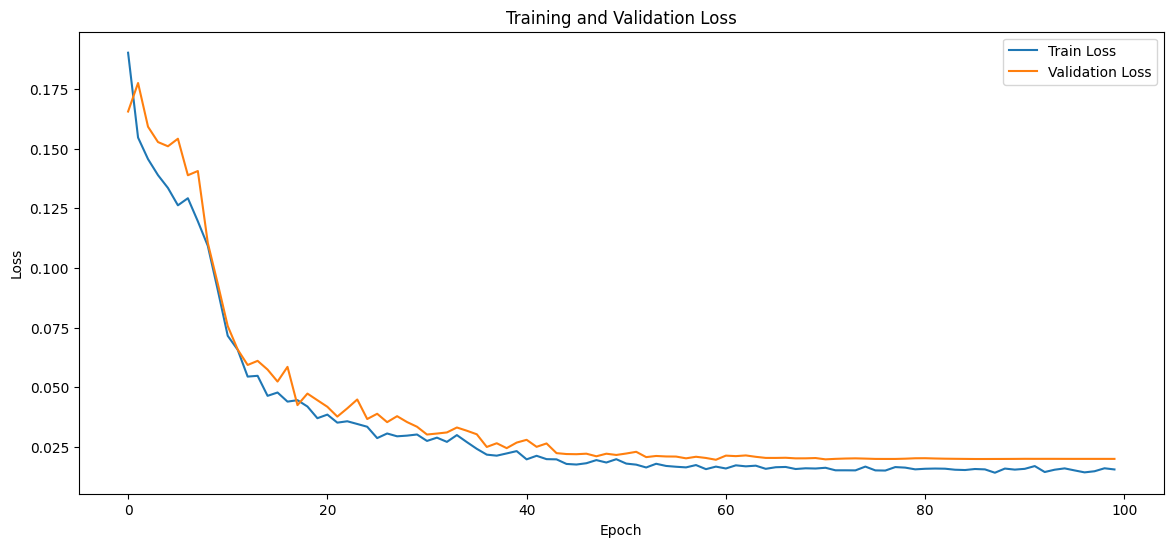

In [21]:
# Vẽ đồ thị loss
plt.figure(figsize=(14, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [18]:
# Load lại mô hình tốt nhất
checkpoint = torch.load('models/TFT5.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"Best model loaded with validation loss: {checkpoint['val_loss']:.4f}")

Best model loaded with validation loss: 0.0196


In [19]:
def get_predictions(loader, model, device):
    model.eval()
    preds = []
    actuals = []
    with torch.no_grad():
        for x_seq, x_cal, y in loader:
            x_seq = x_seq.to(device)
            x_cal = x_cal.to(device)
            outputs = model(x_seq, x_cal)
            preds.append(outputs.cpu().numpy())
            actuals.append(y.numpy())
    preds = np.concatenate(preds, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    return preds, actuals

In [20]:
# Dự báo trên tập train và test
train_preds, train_actuals = get_predictions(train_loader, model, device)
test_preds, test_actuals = get_predictions(test_loader, model, device)

# Inverse transform để đưa về thang đo ban đầu
train_preds_inv = scaler.inverse_transform(train_preds)
train_actuals_inv = scaler.inverse_transform(train_actuals)
test_preds_inv = scaler.inverse_transform(test_preds)
test_actuals_inv = scaler.inverse_transform(test_actuals)

# Tính các chỉ số đánh giá trên tập test
r2 = r2_score(test_actuals_inv, test_preds_inv)
mape = mean_absolute_percentage_error(test_actuals_inv, test_preds_inv)
rmse = np.sqrt(mean_squared_error(test_actuals_inv, test_preds_inv))
print(f"Test R-squared: {r2:.4f}")
print(f"Test MAPE: {mape:.4f}")
print(f"Test RMSE: {rmse:.4f}")

Test R-squared: 0.9426
Test MAPE: 0.4552
Test RMSE: 184094.5781


In [23]:
# Tính các chỉ số riêng cho Units và Revenue
r2_units = r2_score(test_actuals_inv[:, 0], test_preds_inv[:, 0])
mape_units = mean_absolute_percentage_error(test_actuals_inv[:, 0], test_preds_inv[:, 0])
rmse_units = np.sqrt(mean_squared_error(test_actuals_inv[:, 0], test_preds_inv[:, 0]))

print(f"Test Units R-squared: {r2_units:.4f}")
print(f"Test Units MAPE: {mape_units:.4f}")
print(f"Test Units RMSE: {rmse_units:.4f}")

r2_revenue = r2_score(test_actuals_inv[:, 1], test_preds_inv[:, 1])
mape_revenue = mean_absolute_percentage_error(test_actuals_inv[:, 1], test_preds_inv[:, 1])
rmse_revenue = np.sqrt(mean_squared_error(test_actuals_inv[:, 1], test_preds_inv[:, 1]))

print(f"Test Revenue R-squared: {r2_revenue:.4f}")
print(f"Test Revenue MAPE: {mape_revenue:.4f}")
print(f"Test Revenue RMSE: {rmse_revenue:.4f}")

Test Units R-squared: 0.9505
Test Units MAPE: 0.5351
Test Units RMSE: 28.7649
Test Revenue R-squared: 0.9347
Test Revenue MAPE: 0.3753
Test Revenue RMSE: 260349.1094


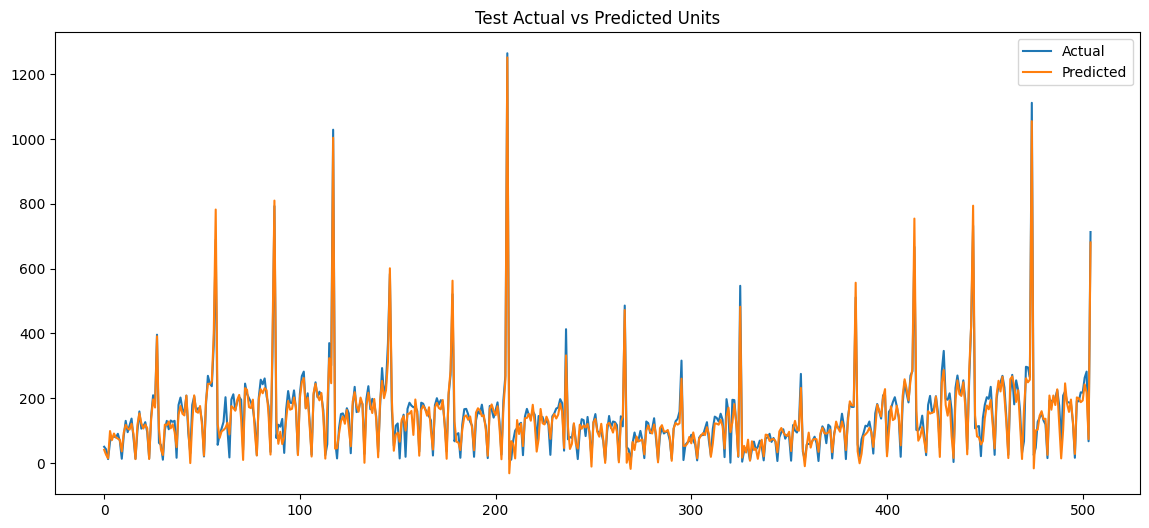

In [24]:
# Vẽ đồ thị dự báo và thực tế đối với Units
plt.figure(figsize=(14, 6))
plt.plot(test_actuals_inv[:, 0], label='Actual')
plt.plot(test_preds_inv[:, 0], label='Predicted')
plt.title('Test Actual vs Predicted Units')
plt.legend()
plt.show()

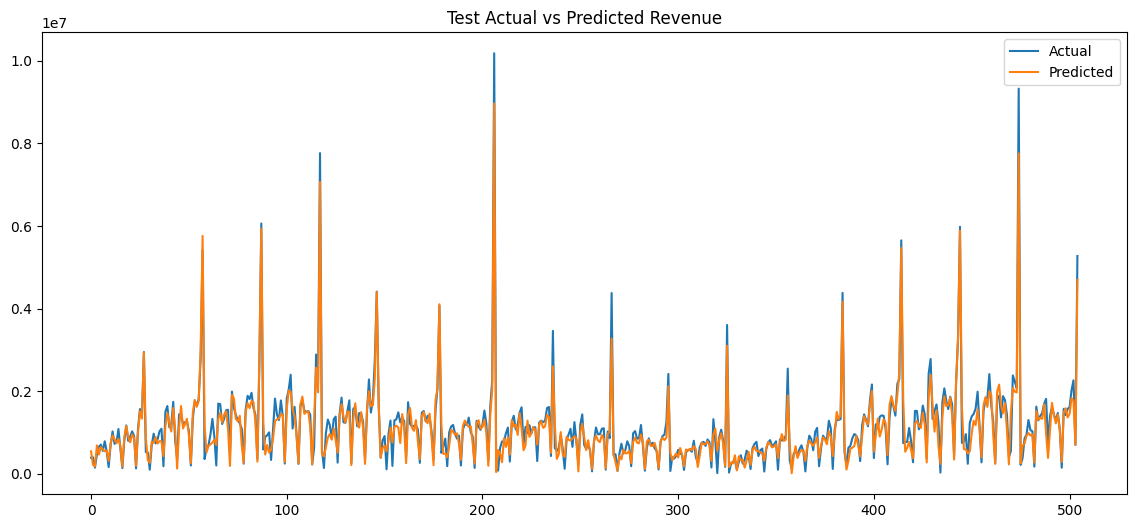

In [25]:
# Vẽ đồ thị dự báo và thực tế đối với Revenue
plt.figure(figsize=(14, 6))
plt.plot(test_actuals_inv[:, 1], label='Actual')
plt.plot(test_preds_inv[:, 1], label='Predicted')
plt.title('Test Actual vs Predicted Revenue')
plt.legend()
plt.show()

In [27]:
num_params = sum(p.numel() for p in model.parameters())

print(f"Number of parameters: {num_params}")

Number of parameters: 632558
